In [1]:
from collections import Counter
import mido
import os
import pandas


def mido_setup():
    mido.set_backend('mido.backends.rtmidi')
    mido.open_output()
    mido.open_output(name='foo', virtual=True)

mido_setup()

In [2]:
def get_song_metadata(track):
    tempo = -1
    time_numerator = -1
    time_denominator = -1
    key = ""
    for msg in track:
        if msg.type == 'time_signature':
            time_numerator = msg.numerator
            time_denominator = msg.denominator
        if msg.type == 'key_signature':
            key = msg.key
        if msg.type == 'set_tempo':
            tempo = msg.tempo

    return key, tempo, time_numerator, time_denominator

def test_get_song_metadata():
    real = mido.MidiFile('../../songs/large_db/jazz_kaggle/AintNothingLikeRealThingBaby.mid')
    key, tempo, time_numerator, time_denominator = get_song_metadata(real.tracks[0])
    if key != 'Eb' or tempo != 582524 or time_numerator != 4 or time_denominator != 4:
        return False
    return True

test_get_song_metadata()

True

In [3]:
def get_instrument_track_data(track):
    instrument = -1
    notes = []
    durations = []
    for msg in track:
            if msg.type == 'program_change':
                instrument = msg.program

            if msg.type == 'note_on':
                notes.append(msg.note)
                durations.append(msg.time)
    return instrument, notes, durations

def test_get_instrument_track_data():
    real = mido.MidiFile('../../songs/large_db/jazz_kaggle/AintNothingLikeRealThingBaby.mid')
    track = real.tracks[1]
    instrument, notes, durations = get_instrument_track_data(track)
    if instrument == -1 or len(notes) == 0 or len(durations) == 0:
        return False
    return True

test_get_instrument_track_data()

True

In [4]:
def get_song_data(song):
    if len(song.tracks) < 5 or len(song.tracks[0]) > 20:
        #error
            return -1, -1, -1, -1, -1, -1, -1, [], [], []

    ticks_per_beat = song.ticks_per_beat
    length = song.length
    number_of_tracks = len(song.tracks)

    key, tempo, time_numerator, time_denominator = get_song_metadata(song.tracks[0])

    # get 4 most played instruments
    tracks = song.tracks[1:]
    tracks.sort(key = len, reverse=True)
    tracks = tracks[:4]

    instruments = []
    notes = []
    durations = []
    for track in tracks:
        instrument, n, d = get_instrument_track_data(track)
        instruments.append(instrument)
        notes = notes + n
        durations = durations + d

    repeats = []
    for instrument in instruments:
        if instrument not in instruments:
            repeats.append(instrument)
    all_instruments_different = False
    if len(repeats) == 4:
        all_instruments_different = True
    return ticks_per_beat, length, number_of_tracks, key, tempo, time_numerator, time_denominator, instruments, all_instruments_different, notes, durations


def test_get_song_data():
    real = mido.MidiFile('../../songs/large_db/jazz_kaggle/AintNothingLikeRealThingBaby.mid')
    data = get_song_data(real)
    if data[0] == -1 or len(data[7]) == 0:
        return False
    return True
test_get_song_data()

True

In [5]:
def load_songs(path):
    songs = []
    for _, _, filenames in os.walk(path):
        for filename in filenames:
            try:
                song = mido.MidiFile(path + filename)
                print("Loading song: " + filename)
                songs.append(song)
            except:
                print("Error loading: " + filename + " will delete")
                os.remove(path + filename)
    print("Done loading songs")
    return  songs

In [6]:
jazz_songs_path = '../../songs/large_db/jazz_kaggle/'
songs = load_songs(jazz_songs_path)

Loading song: GlasgowKiss.mid
Loading song: Swear.mid
Loading song: HowDoYouKeepTheMusicPlaying.mid
Loading song: MessageOfLove.mid
Loading song: Spiderman.mid
Loading song: KnocksMeOffMyFeet.mid
Loading song: Fallen.mid
Loading song: JungiNishan.mid
Loading song: Alone.mid
Loading song: OnlyTheYoung.mid
Loading song: Tracie.mid
Loading song: AWomansWorth.mid
Loading song: BetterDaysAhead.mid
Loading song: MacktheKnife.mid
Loading song: Chinatawn.mid
Loading song: PutYourHandOnMyShoulder.mid
Loading song: IllSaySheDoes.mid
Loading song: LoveIsTheSeventhWave.mid
Loading song: WhosSorryNow.mid
Loading song: YoungAtHeart.mid
Loading song: YoureGonnaBeSorry.mid
Loading song: DamageControl.mid
Loading song: WatermelonMan.mid
Loading song: LilyWasHere.mid
Loading song: Summerwind.mid
Loading song: BeneathADesertMoon.mid
Loading song: WednesdaysChild.mid
Loading song: TheWayYouLookTonight.mid
Loading song: SummerWine.mid
Loading song: AllBlues.mid
Loading song: MyWay.mid
Loading song: IfIHadY

In [7]:
def get_lowest_and_highest_note(songs):
    min = -1
    max = 999
    for song in songs:
        for track in song.tracks:
            for msg in track:
                if msg.type == "note_on":
                    if msg.note < min:
                        min = msg.note
                    if msg.note > max:
                        max = msg.note
    return min, max

min, max = get_lowest_and_highest_note(songs)
print(min, max)

-1 999


In [15]:
def get_song_times(songs):
    times = []
    for song in songs:
        for track in song.tracks:
            time = 480
            for msg in track:
                if msg.type == "note_on":
                    time = time + msg.time
            if time > 5000:
                times.append(time)
    return times

times = get_song_times(songs)

In [16]:
import statistics
print(sum(times)/len(times))
print(statistics.stdev(times))

112622.86646016176
380870.1091142851


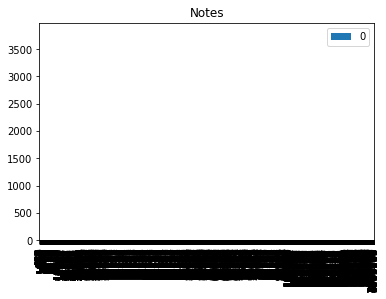

In [13]:
times.sort()
count = Counter(times)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Notes')

In [7]:
def get_songs_data(songs):
    ticks_per_bit = []
    lengths = []
    number_of_tracks = []
    keys = []
    tempos = []
    time_numerators = []
    time_denominators = []
    instruments = []
    notes = []
    notes_per_song = []
    durations = []

    counter = 0
    errors = 0
    for song in songs:
        counter = counter + 1
        if counter % 50 == 0:
            print(str(counter) + "/" + str(len(songs)))
        try:
            tpb, length, noT, key, tempo, time_numerator, time_denominator, instrs, all_instruments_different, nts, durs = get_song_data(song)
            if tpb == -1 and length == -1 and len(instrs) == 0:
                    raise ValueError('Failed to load song')
            ticks_per_bit.append(tpb)
            lengths.append(length)
            number_of_tracks.append(noT)
            keys.append(key)
            tempos.append(tempo)
            time_numerators.append(time_numerators)
            time_denominators.append(time_denominators)
            instruments = instruments + instrs
            notes = notes + nts
            notes_per_song.append(len(nts))
            durations = durations + durs
        except:
            errors = errors + 1

    print("Done. Errors: " + str(errors))
    return ticks_per_bit, lengths, number_of_tracks, keys, tempos, time_numerators, time_denominators, instruments, notes, notes_per_song, durations


In [8]:
ticks_per_bit, lengths, number_of_tracks, keys, tempos, time_numerators, time_denominators, instruments, notes, notes_per_song, durations = get_songs_data(songs)
del songs

50/910
100/910
150/910
200/910
250/910
300/910
350/910
400/910
450/910
500/910
550/910
600/910
650/910
700/910
750/910
800/910
850/910
900/910
Done. Errors: 447


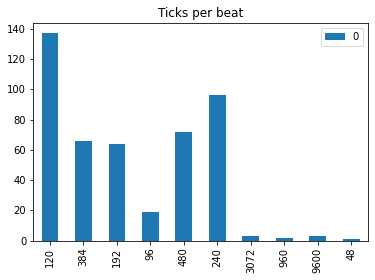

In [35]:
count = Counter(ticks_per_bit)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Ticks per beat')

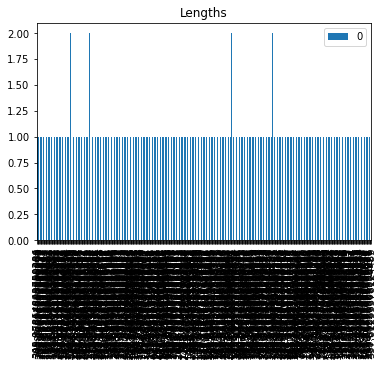

In [36]:
count = Counter(lengths)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Lengths')

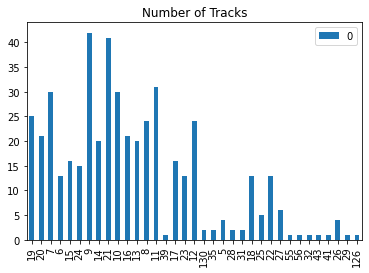

In [37]:
count = Counter(number_of_tracks)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Number of Tracks')


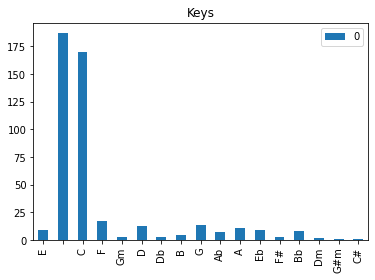

In [38]:
count = Counter(keys)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Keys')


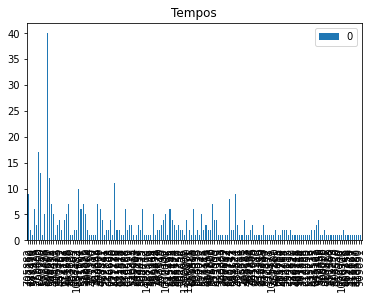

In [39]:
count = Counter(tempos)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Tempos')

In [40]:
count = Counter(time_numerators)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Time Numerators')

TypeError: unhashable type: 'list'

In [ ]:
count = Counter(time_denominators)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Time Denominators')

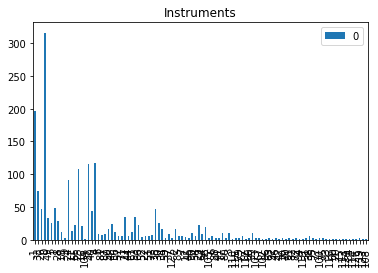

In [41]:
count = Counter(instruments)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Instruments')

In [42]:
print(count)

Counter({0: 316, -1: 197, 4: 117, 32: 115, 25: 108, 24: 91, 33: 74, 1: 49, 26: 47, 35: 47, 40: 44, 27: 34, 53: 34, 49: 33, 28: 29, 5: 26, 30: 25, 48: 24, 65: 23, 29: 23, 66: 22, 16: 21, 36: 19, 50: 17, 34: 16, 2: 16, 11: 14, 18: 12, 56: 12, 61: 12, 90: 10, 17: 10, 3: 10, 39: 10, 87: 9, 37: 9, 8: 8, 64: 8, 81: 7, 73: 7, 57: 6, 44: 6, 51: 6, 54: 6, 71: 5, 22: 5, 85: 5, 7: 5, 6: 5, 62: 5, 38: 5, 52: 4, 12: 4, 59: 3, 127: 3, 45: 3, 105: 3, 88: 3, 79: 3, 89: 3, 63: 3, 46: 3, 31: 3, 9: 2, 41: 2, 80: 2, 115: 2, 103: 2, 67: 2, 10: 2, 91: 2, 72: 2, 95: 2, 100: 2, 75: 2, 19: 2, 104: 1, 110: 1, 112: 1, 102: 1, 96: 1, 92: 1, 42: 1, 70: 1, 82: 1, 94: 1, 119: 1, 77: 1, 93: 1, 116: 1, 60: 1, 20: 1, 15: 1, 113: 1, 124: 1, 84: 1, 114: 1, 126: 1, 123: 1, 108: 1})


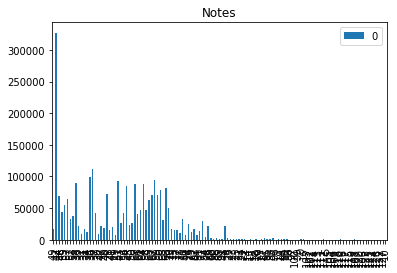

In [14]:
count = Counter(notes)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Notes')

In [ ]:
count = Counter(notes_per_song)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Notes per song')

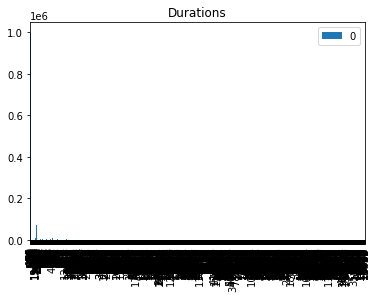

In [10]:
count = Counter(durations)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Durations')


there was an error


In [16]:
import operator
count = Counter(instruments)
count = Counter(notes_per_song)
t = sorted(count.items(), key=operator.itemgetter(1), reverse=True)[:5]
print(t)

[(14742, 3), (4100, 3), (2737, 3), (7370, 2), (5490, 2)]
